In [1]:
import os
import torch
from d2l import torch as d2l

下载和预处理数据集

In [2]:
d2l.DATA_HUB['fra-eng'] = (
    d2l.DATA_URL + 'fra-eng.zip',
    '94646ad1522d915e7b0f9296181140edcf86a4f5'
)

In [3]:
def read_data_nmt():
    # 载入“英语-法语”数据集
    data_dir = d2l.download_extract('fra-eng')
    with open(
        os.path.join(
            data_dir,
            'fra.txt'
        ),
        'r',
        encoding='utf-8'
    ) as f:
        return f.read()


In [4]:
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [5]:
'''
- `preprocess_nmt` 函数对读取的文本数据进行预处理。
- 内部的 `no_space` 函数用于判断在标点符号前是否应该插入空格
（如果前一个字符不是空格且当前字符是标点符号，则需要插入空格）。
- `text.replace` 将不间断空格替换为空格，并将大写字母转为小写。
- 列表推导式 `out` 遍历每个字符，根据 `no_space` 函数的判断，
在必要时在标点符号前插入空格。
- 最后，`''.join(out)` 将字符列表合并成一个字符串并返回。
- `text[:80]` 这一行打印预处理后的文本前80个字符，以检查预处理是否正确。

no_space 函数用于检查当前字符 char 是否是标点符号
（逗号、句号、感叹号或问号），并且前一个字符 prev_char 是否不是空格。


- `\u202f` 和 `\xa0` 都是不间断空格字符（non-breaking space）。
  - `\u202f` 是窄不间断空格（narrow no-break space）。
  - `\xa0` 是普通的不间断空格（non-breaking space）。
- 这两个字符在某些语言（如法语）的排版中常用于防止自动换行。这里的作用是将这些特殊的空格字符替换为普通的空格 `' '`，以便后续处理。

  
'''
def preprocess_nmt(text):
    # 预处理 “英语-法语”数据集
    def no_space(char, prev_char):
        return char in set(',.|?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符合之间插入空格
    out = [
        ' ' + char if i > 0 and no_space(char, text[i-1]) else char
        for i, char in enumerate(text)
    ]
    return ''.join(out)

In [6]:
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run!	cours !
run!	courez !
who ?	qui ?
wow!	ça alors !
fi


词元化

In [7]:
'''
`tokenize_nmt` 函数将英语－法语数据集的文本进行词元化处理，
即将每一行的句子拆分成单词列表。
这个函数处理的数据集格式假设每一行都是一个英语句子和一个法语句子，
中间用制表符（`\t`）分隔。

参数解释
- `text`：输入的多行字符串，每一行包含一个英语句子和一个法语句子，
中间用制表符分隔。
- `num_examples`（可选）：指定只处理前 `num_examples` 行数据。
如果未指定或为 `None`，则处理所有行。

**初始化列表**：
   source, target = [], []
   - `source` 用于存储英语句子的词元（单词）列表。
   - `target` 用于存储法语句子的词元（单词）列表。

**逐行处理文本**：
   for i, line in enumerate(text.split('\n')):
   - 使用 `split('\n')` 将整个文本按行分割，逐行处理。
   - `enumerate` 函数同时返回行号 `i` 和行内容 `line`。

**控制处理行数**：
   if num_examples and i > num_examples:
       break
   - 如果指定了 `num_examples`，且当前行号 `i` 大于 `num_examples`，
   则停止处理。

**分割每行的句子**：
   parts = line.split('\t')
   if len(parts) == 2:
   - 使用 `split('\t')` 将行内容按制表符分割成两个部分：
   `parts[0]` 为英语句子，`parts[1]` 为法语句子。
   - 只有当分割结果 `parts` 的长度为2时，
   才处理该行（保证该行确实包含一个英语句子和一个法语句子）。

**词元化并存储**：
   source.append(parts[0].split(' '))
   target.append(parts[1].split(' '))
   - 将英语句子 `parts[0]` 按空格分割成单词列表，
   并添加到 `source` 列表中。
   - 将法语句子 `parts[1]` 按空格分割成单词列表，
   并添加到 `target` 列表中。

**返回结果**：
   return source, target
   - 返回两个列表：`source` 和 `target`，
   分别包含英语和法语句子的词元列表。

'''
def tokenize_nmt(text, num_examples=None):
    # 词元化“英语-法语”数据集
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [8]:
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'], ['hi', '.'], ['run!'], ['run!'], ['who', '?'], ['wow!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

In [9]:
def show_list_len_pair_hist(
    legend, xlabel, ylabel, xlist, ylist
):
    # 绘制列表长度对
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [
            [len(l) for l in xlist],
            [len(l) for l in ylist]
        ]
    )
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)
    

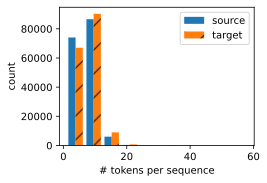

In [10]:
show_list_len_pair_hist(
    ['source', 'target'],
    '# tokens per sequence',
    'count',
    source,
    target
);

词表

In [11]:
src_vocab = d2l.Vocab(
    source, 
    min_freq=2, 
    reserved_tokens=['<pad>', '<bos>', '<eos>']
)

len(src_vocab)

10221

加载数据集

In [12]:
def truncate_pad(line, num_steps, padding_token):
    # 截断或填充文本序列
    '''
    src_vocab[source[0]]: [47, 4]
    line: [47, 4]
    len(line): 2
    '''
    if len(line) > num_steps:
        return line[:num_steps] # 截断
    '''
    line: [47, 4]
    len(line): 2
    
    line + [padding_token] * (num_steps - len(line)): 
    [47, 4, 1, 1, 1, 1, 1, 1, 1, 1]
    '''
    return line + [padding_token] * (num_steps - len(line)) # 填充

In [13]:
'''
source[0]: ['go', '.']
src_vocab[source[0]]: [47, 4]
'''
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
def build_array_nmt(lines, vocab, num_steps):
    # 将机器翻译的文本序列转化成小批量
    lines = [
        vocab[l] for l in lines
    ]
    lines = [
        l + [vocab['<eos>']] for l in lines
    ]
    array = torch.tensor(
        [
            truncate_pad(
                l, num_steps, vocab['<pad>']
            ) for l in lines
        ]
    )
    valid_len = (
        array != vocab['<pad>']
    ).type(torch.int32).sum(1)
    return array, valid_len
    
    

训练模型

In [15]:
def load_data_nmt(
    batch_size, num_steps, num_examples=600
):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(
        source, 
        min_freq=2,
        reserved_tokens=['<pad>', '<bos>', '<eos>']
    )
    tgt_vocab = d2l.Vocab(
        target, 
        min_freq=2,
        reserved_tokens=['<pad>', '<bos>', '<eos>']
    )
    src_array, src_valid_len = build_array_nmt(
        source, src_vocab, num_steps
    )
    tgt_array, tgt_valid_len = build_array_nmt(
        target, tgt_vocab, num_steps
    )
    data_arrays = (
        src_array,
        src_valid_len,
        tgt_array,
        tgt_valid_len
    )
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [16]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(
    batch_size=2, num_steps=8
)

In [17]:
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print("X:", X.type(torch.int32))
    print("X的有效长度：", X_valid_len)
    print("Y:", Y.type(torch.int32))
    print("Y的有效长度：",Y_valid_len)
    break

X: tensor([[  6, 138,   3,   1,   1,   1,   1,   1],
        [  0,   9,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度： tensor([3, 4])
Y: tensor([[ 6,  7,  0,  5,  3,  1,  1,  1],
        [59,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度： tensor([5, 3])
